## Описание проекта. Телеком


Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. 

Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. 

Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. 

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. 

Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

## Описание услуг
Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:

- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. 

Доступны различные способы расчёта и возможность получить электронный чек.

In [118]:
import pandas as pd
# import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

from sqlalchemy import create_engine 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import ( 
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RepeatedStratifiedKFold
)

from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder


from sklearn.compose import ColumnTransformer
from sklearn.cluster import MiniBatchKMeans

from sklearn.metrics import (
    ConfusionMatrixDisplay, 
    make_scorer,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    precision_recall_curve
)

from imblearn.pipeline import Pipeline 
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

RANDOM_STATE = 270822

## Описание данных

Таблица contract
- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Таблица personal
- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Таблица internet
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Таблица phone
- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020.

## Загрузка данных

In [119]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-final' # название базы данных,
}
 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string) 

In [120]:
contract = pd.read_sql_query('''
SELECT * FROM telecom.contract
''', con=engine) 

personal = pd.read_sql_query('''
SELECT * FROM telecom.personal
''', con=engine) 

internet = pd.read_sql_query('''
SELECT * FROM telecom.internet
''', con=engine) 

phone = pd.read_sql_query('''
SELECT * FROM telecom.phone
''', con=engine)

In [121]:
print(contract.info())
display(contract.head(10))

print(personal.info())
display(personal.head(10))

print(internet.info())
display(internet.head(10))

print(phone.info())
display(phone.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB
None


,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No
6,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
7,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
8,6713-OKOMC,DSL,Yes,No,No,No,No,No
9,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes
6,7892-POOKP,Yes
7,6388-TABGU,No
8,9763-GRSKD,No
9,7469-LKBCI,No


In [122]:
internet.columns = internet.iloc[0].values
internet = internet.iloc[1:].reset_index(drop=True)

phone.columns = phone.iloc[0].values
phone = phone.iloc[1:].reset_index(drop=True)


In [123]:
display(phone.head())
display(internet.head())

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [124]:
contract['Target'] = contract['EndDate'].isna().astype(int)

### Вывод:
Был создан Target из EndDate, изменен формат internet и phone, чтобы корректно отобразить названия колонок.

## Исследовательский анализ и предобработка данных

Найдем причину пропусков в TotalCharges. Как видно это потому, что дата начала это 01/02/2020, то есть TotalCharges = MonthlyCharges.

Заполним пропуски и преобразуем типы.

In [125]:
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN,1
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN,1
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN,1
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN,1
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN,1
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN,1
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.70,NaN,1
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.90,NaN,1
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,NaN,1
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20.00,NaN,1


In [126]:
contract.loc[contract['TotalCharges'].isna(), 'TotalCharges'] = contract['MonthlyCharges']
contract['EndDate'] = contract['EndDate'].fillna('2020-02-01')
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

In [127]:
contract['Target'].value_counts()

Target
1    5174
0    1869
Name: count, dtype: int64

In [128]:
print(contract.info())
display(contract.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Target            7043 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(1), object(4)
memory usage: 467.8+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,1
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,1
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,0
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,1
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,0
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,0
6,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,25.75,1
7,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,56.05,1
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,0
9,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,25.35,1


Контракты есть у всех но кто-то пользуется интернетом, кто-то телефоном, а кто-то и тем и другим.

In [129]:
df = contract.merge(personal, on='customerID').merge(internet, how='left', on='customerID').merge(phone, how='left', on='customerID')

In [130]:
df = df.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})

In [131]:
display(df.head())
print(df.info())
display(df.describe())

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,1,Female,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,1,Male,...,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,0,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,1,Female,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,0,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Target            7043 non-null   int32         
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

,BeginDate,EndDate,MonthlyCharges,TotalCharges,Target,SeniorCitizen
count,7043,7043,7043.000000,7043.000000,7043.000000,7043.000000
mean,2019-03-20 03:51:02.274599168,2020-01-11 12:56:19.696152064,64.761692,2279.798992,0.734630,0.162147
min,2018-04-17 00:00:00,2019-10-01 00:00:00,18.250000,18.800000,0.000000,0.000000
25%,2019-01-18 12:00:00,2020-01-01 00:00:00,35.500000,398.550000,0.000000,0.000000
50%,2019-03-22 00:00:00,2020-02-01 00:00:00,70.350000,1394.550000,1.000000,0.000000
75%,2019-05-21 00:00:00,2020-02-01 00:00:00,89.850000,3786.600000,1.000000,0.000000
max,2020-02-01 00:00:00,2020-02-01 00:00:00,118.750000,8684.800000,1.000000,1.000000
std,NaN,NaN,30.090047,2266.730170,0.441561,0.368612


In [132]:
na_columns = df.columns[df.isna().sum().astype(bool)]
for i in na_columns:
    print(df[i].unique())

['DSL' nan 'Fiber optic']
['Yes' nan 'No']
['No' nan 'Yes']
['Yes' nan 'No']
['Yes' nan 'No']
['Yes' nan 'No']
['No' nan 'Yes']
[nan 'No' 'Yes']


In [133]:
for i in na_columns:
    df[i] = df[i].fillna('No')

In [134]:
len(df['CustomerID'].unique())

7043

In [135]:
print(df['SeniorCitizen'].value_counts())
df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64


Добавим числовой признак - разницу между начальной и конечной датой, в днях

In [136]:
df['Days'] = (df['EndDate'] - df['BeginDate']).dt.days

In [137]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Target            7043 non-null   int32         
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int32         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

In [138]:
categorical = [
    'Type', 
    'PaperlessBilling', 
    'PaymentMethod',
    'Gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines'
]

continuous = [
    'Days',
    'MonthlyCharges', 
    'TotalCharges'
]

target = 'Target'

In [139]:
for i in categorical:
    print(i, df[i].unique())

Type ['Two year' 'Month-to-month' 'One year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Bank transfer (automatic)' 'Mailed check' 'Electronic check'
 'Credit card (automatic)']
Gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['Yes' 'No']
InternetService ['DSL' 'No' 'Fiber optic']
OnlineSecurity ['Yes' 'No']
OnlineBackup ['No' 'Yes']
DeviceProtection ['Yes' 'No']
TechSupport ['Yes' 'No']
StreamingTV ['Yes' 'No']
StreamingMovies ['No' 'Yes']
MultipleLines ['No' 'Yes']


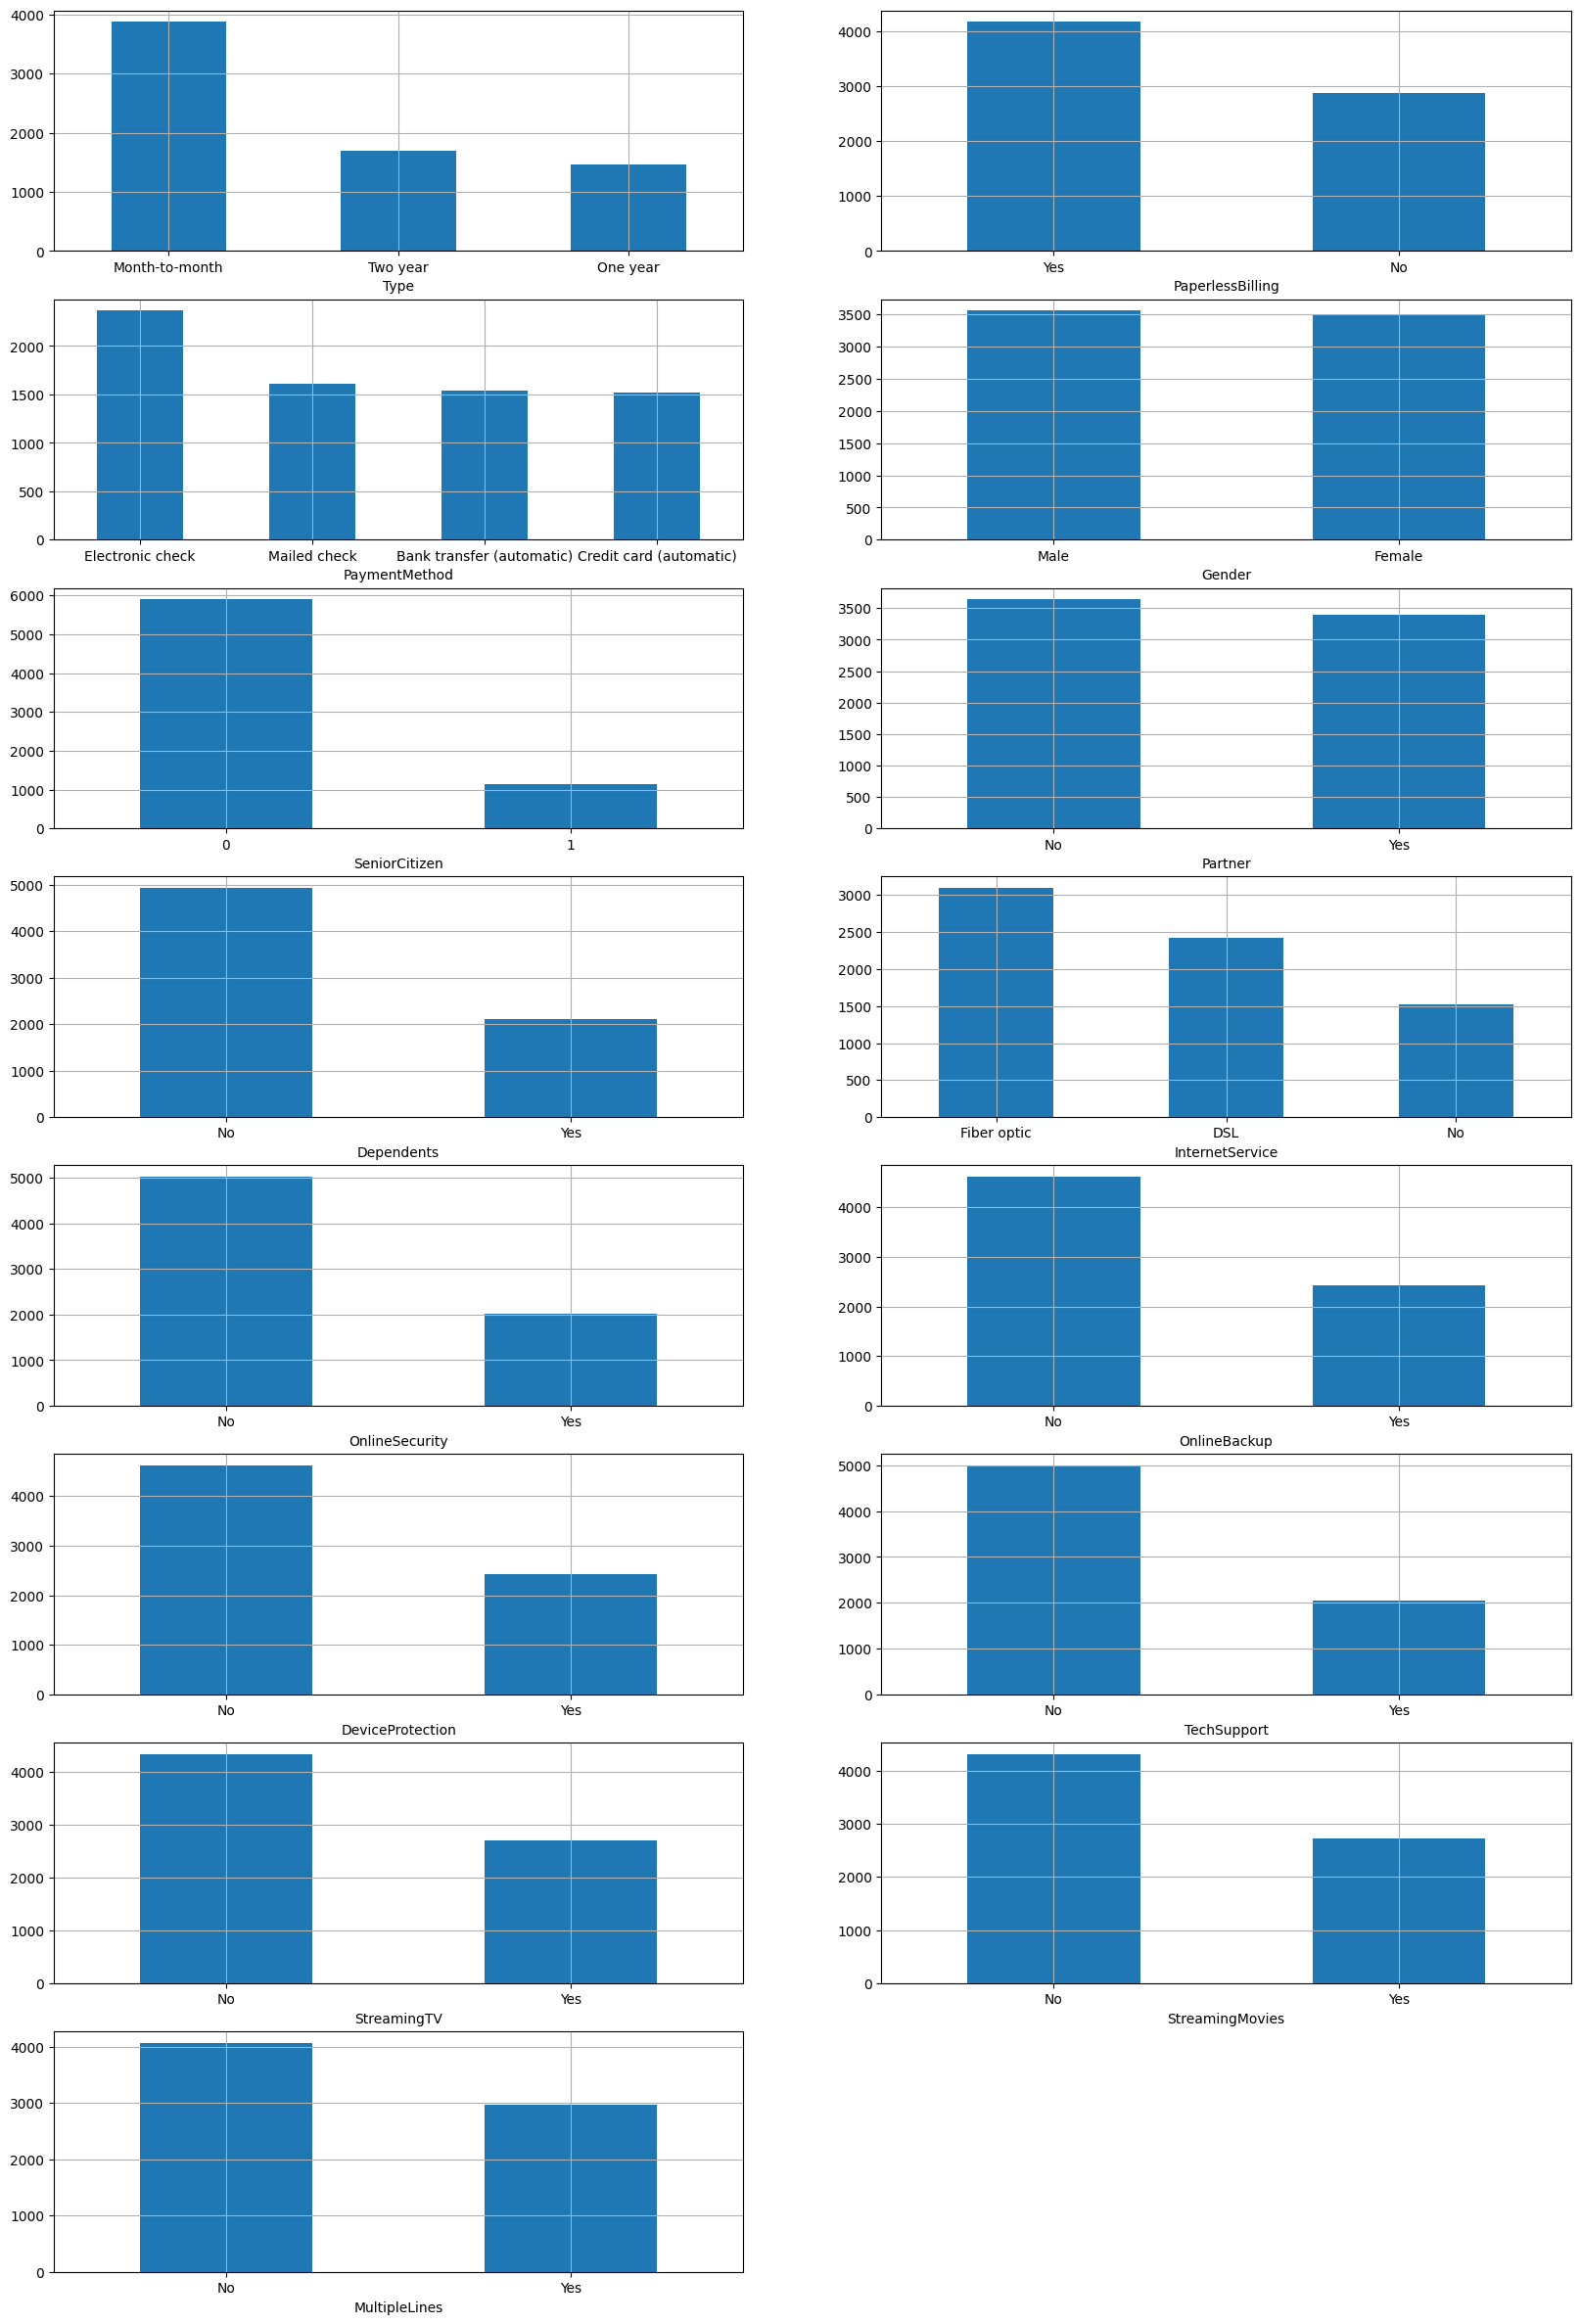

In [140]:
plt.figure(figsize=(20, 30))

for idx, column in enumerate(categorical):
    ax = plt.subplot(8, 2, idx + 1)
    
    df[column].value_counts().plot(
        kind='bar', 
        ax=ax,
        rot=0,
    )
    ax.grid()
    
plt.show()
        

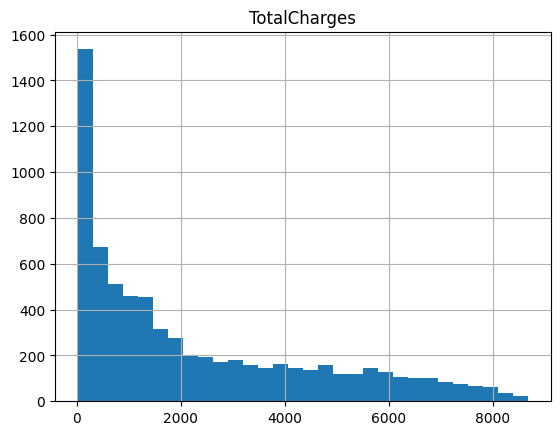

In [141]:
plt.hist(df['TotalCharges'], bins=30)
plt.title('TotalCharges')
plt.grid(True)

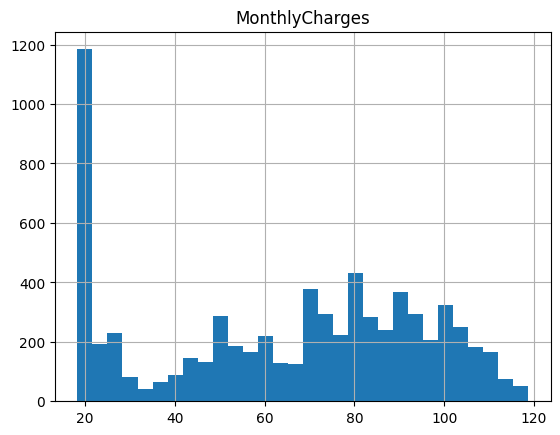

In [142]:
plt.hist(df['MonthlyCharges'], bins=30)
plt.title('MonthlyCharges')
plt.grid(True)

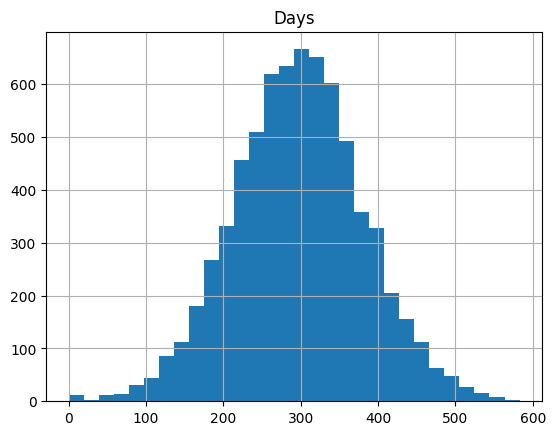

In [143]:
plt.hist(df['Days'], bins=30)
plt.title('Days')
plt.grid(True)

## Обучение модели

In [144]:
df = df[categorical + continuous + [target]]

In [145]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=RANDOM_STATE)

features_train = df_train[categorical + continuous]
target_train = df_train[target]

features_test = df_test[categorical + continuous]
target_test = df_test[target]

In [146]:
continuous_pipeline = Pipeline([('scaler', StandardScaler())])

linear_processor = ColumnTransformer(transformers=[
    ('number', continuous_pipeline, continuous),
    ('category', Pipeline([('OHE', OneHotEncoder())]), categorical)
])

boosting_processor = ColumnTransformer(transformers=[
    ('number', continuous_pipeline, continuous),
    ('category', Pipeline([('OE', OrdinalEncoder())]), categorical)
])


### LogisticRegression

In [147]:
lr_pl = Pipeline([('preprocess', linear_processor), ('ro', RandomOverSampler()), ('clf', LogisticRegression())])
grid = GridSearchCV(lr_pl, param_grid={}, cv=3, scoring='f1')
model_lr = grid.fit(features_train, target_train)

In [148]:
print(f'F1 = {model_lr.best_score_}')

F1 = 0.802835915331665


### CatBoostRegressor

In [157]:
cb_pl = Pipeline([('preprocess', boosting_processor), ('ro', RandomOverSampler()), ('clf', CatBoostClassifier(verbose=300))])

grid_space = {'clf__depth': [5], 'clf__l2_leaf_reg': [9], 'clf__learning_rate': [0.1]}
# grid_space = {
#     'clf__learning_rate': [0.1, 0.3],
#     # 'iterations': [50, 100],
#     'clf__depth': [3, 5],
#     'clf__l2_leaf_reg': [3, 9]
# }

# grid_space = { 'clf__depth': [3, 5], 'clf__learning_rate': np.arange(0.1, 0.5, 0.2) }
# grid_space = { 'clf__depth': [3], 'clf__learning_rate': [0.1] }

grid = GridSearchCV(cb_pl, param_grid=grid_space, cv=3, scoring='f1')
model_cb = grid.fit(features_train, target_train)

0:	learn: 0.6517685	total: 3.52ms	remaining: 3.52s
300:	learn: 0.2926371	total: 1.06s	remaining: 2.46s
600:	learn: 0.2079313	total: 2.12s	remaining: 1.41s
900:	learn: 0.1575088	total: 3.12s	remaining: 343ms
999:	learn: 0.1430964	total: 3.46s	remaining: 0us
0:	learn: 0.6504823	total: 3.29ms	remaining: 3.29s
300:	learn: 0.2793780	total: 980ms	remaining: 2.27s
600:	learn: 0.1973473	total: 1.99s	remaining: 1.32s
900:	learn: 0.1463115	total: 2.99s	remaining: 329ms
999:	learn: 0.1351587	total: 3.35s	remaining: 0us
0:	learn: 0.6485410	total: 3.29ms	remaining: 3.29s
300:	learn: 0.2778254	total: 1s	remaining: 2.33s
600:	learn: 0.2022627	total: 2.01s	remaining: 1.33s
900:	learn: 0.1533628	total: 2.98s	remaining: 328ms
999:	learn: 0.1429409	total: 3.32s	remaining: 0us
0:	learn: 0.6482298	total: 3.71ms	remaining: 3.71s
300:	learn: 0.3265665	total: 1.14s	remaining: 2.65s
600:	learn: 0.2530115	total: 2.33s	remaining: 1.55s
900:	learn: 0.2028778	total: 3.49s	remaining: 384ms
999:	learn: 0.1896785	tot

In [159]:
print(f'F1 = {model_cb.best_score_}')

F1 = 0.8384673373514374


In [160]:
best_estimator = model_cb.best_estimator_

## Тестирование модели и демонстрация её работы

In [161]:
best_estimator.fit(features_train, target_train)
predict = best_estimator.predict(features_test)
print(f'F1 = {f1_score(target_test, predict)}')

0:	learn: 0.6514915	total: 3.94ms	remaining: 3.94s
300:	learn: 0.3313575	total: 1.16s	remaining: 2.69s
600:	learn: 0.2550673	total: 2.31s	remaining: 1.54s
900:	learn: 0.2032615	total: 3.52s	remaining: 386ms
999:	learn: 0.1909578	total: 3.92s	remaining: 0us
F1 = 0.8369477911646588


In [162]:
feature_importances = pd.DataFrame(best_estimator._final_estimator.feature_importances_, index=df.columns.drop(target), columns=['importances']).sort_values(by='importances')
display(feature_importances)

,importances
StreamingMovies,1.083786
OnlineSecurity,1.317553
Days,1.370136
InternetService,1.480066
MonthlyCharges,1.544764
TechSupport,1.570809
StreamingTV,1.738478
Dependents,1.860266
OnlineBackup,1.931591
MultipleLines,2.085104


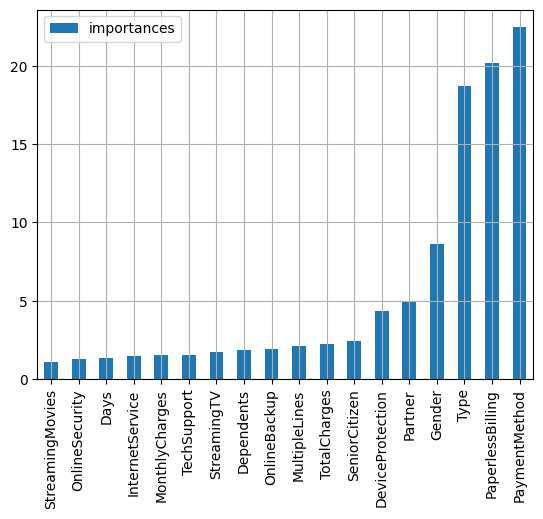

In [163]:
feature_importances.plot(kind='bar')
plt.grid()
None